In [1]:
import os, time
import pandas as pd
import h5py

%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Create timestamp to show when this summary was run
print 'Summary run: ' + time.strftime("%a, %d %b %Y %H:%M")

Summary run: Wed, 29 Aug 2018 10:41


In [3]:
# Daysim data
trip = pd.read_csv(r'../../../outputs/daysim/_trip.tsv', sep='\t')
person = pd.read_csv(r'../../../outputs/daysim/_person.tsv', sep='\t')
hh = pd.read_csv(r'../../../outputs/daysim/_household.tsv', sep='\t')

In [4]:
pd.options.display.float_format = '{:0,.2f}'.format

In [5]:
# Weekdays in year
annual_factor = 300

# Soundcast Metrics
----

### Average Daily Miles Driven per Person

In [6]:
df = pd.read_excel(r'../../../outputs/network/network_summary.xlsx', sheetname='VMT by UC').reset_index()
df.index = df.tod
tot_vmt = df.drop(['@lttrk','@mveh','@hveh','@bveh','tod'], axis=1).sum().sum()
tot_pop = person['psexpfac'].sum()
x = tot_vmt/tot_pop
print '{:0,.1f}'.format(x)

17.0


### Hours of Congestion per Person per Year
For average Puget Sound resident:

In [7]:
net_sum = pd.read_excel(r'../../../outputs/network/network_summary.xlsx', sheetname='Delay by UC')
df.index = df.tod
veh_delay = net_sum.drop(['@lttrk','@mveh','@hveh','@bveh','tod'], axis=1).sum().sum()
tot_pop = person['psexpfac'].sum()
x = (veh_delay/tot_pop)*annual_factor
print '{:0,.1f}'.format(x)

47.8


### Annual Hours of Delay by Average Truck
Average annual delay (hours) per truck trip in and through the region:

In [8]:
# Total truck trips

In [9]:
# Load truck trips
df = pd.read_csv(r'../../../outputs/network/trucks.csv')

# Truck delay
net_sum = pd.read_excel(r'../../../outputs/network/network_summary.xlsx', sheetname='Delay by UC')

# Annual delay hours
daily_delay = net_sum[['@mveh','@hveh']].sum().sum()


# total truck trips
trips = df['prod'].sum()

# average annual delay hours per truck
x = (daily_delay*annual_factor)/trips
print'{:0,.1f}'.format(x)

116.9


*Medium trucks only:*

In [10]:
x = (net_sum['@mveh'].sum()*annual_factor)/df[df['Unnamed: 0'] == 'mt']['prod'].values[0]
print '{:0,.1f}'.format(x)

98.3


*Heavy trucks only:*

In [11]:
x = (net_sum['@hveh'].sum()*annual_factor)/df[df['Unnamed: 0'] == 'ht']['prod'].values[0]
print '{:0,.1f}'.format(x)

204.1


### % Population Walking or Biking for Transportation

In [12]:
trip_person = pd.merge(trip,person,on=['hhno','pno'], how='left')
bike_walk_trips = trip_person[trip_person['mode'].isin([1,2])]

df = bike_walk_trips.groupby(['hhno','pno']).count()
df = df.reset_index()
df = df[['hhno','pno']]
df['bike_walk'] = True

df = pd.merge(person,df,on=['hhno','pno'], how='left')
df['bike_walk'] = df['bike_walk'].fillna(False)

pd.options.display.float_format = '{:,.1%}'.format
df = pd.DataFrame(df.groupby('bike_walk').sum()['psexpfac']/df['psexpfac'].sum())
print '{:,.1%}'.format(df.loc[True]['psexpfac'])

24.5%


## Household and Jobs within 1/4 mile transit

In [13]:
# Network data
df = pd.read_excel(r'../../../outputs/transit/transit_summary.xlsx', sheetname='Transit Job Access')

**Households**

In [14]:
x = df.loc['hh_p']['quarter_mile_transit']
print '{:,.0f}'.format(x) + " households within 1/4 mile of transit"
x = (df.loc['hh_p']['quarter_mile_transit']*1.0)/df.loc['hh_p']['total']
print '{:,.1%}'.format(x) + " of total households"

1,449,018 households within 1/4 mile of transit
60.0% of total households


**Jobs**

In [15]:
x = df.loc['emptot_p']['quarter_mile_transit']
print '{:,.0f}'.format(x) + " jobs within 1/4 mile of transit"
x = (df.loc['emptot_p']['quarter_mile_transit']*1.0)/df.loc['emptot_p']['total']
print '{:,.1%}'.format(x) + " of total jobs"

2,400,065 jobs within 1/4 mile of transit
71.8% of total jobs


### Highway Peak Period Travel Times
(Zone to Zone travel times)

In [16]:
# Load observed data (2013 currently)
od_obs = pd.read_csv(r'..\..\..\scripts\summarize\inputs\network_summary\od_travel_times.csv')

**AM Travel Times**

In [17]:
user_class = 'svtl1t'
max_internal_zone = 3700
zone_list = [532,1552,2570,2286,3108,3625,3528,1653,1178,1354,973]

corridor_list = ['Bremerton-Silverdale','Tacoma-Seattle','Everett-Seattle','Redmond-Seattle','Bellevue-Seattle',
                'Auburn-Renton','Lynnwood-Bellevue','Tukwila-Bellevue',
                'Silverdale-Bremerton','Seattle-Tacoma','Seattle-Everett','Seattle-Redmond','Seattle-Bellevue',
                'Renton-Auburn','Bellevue-Lynnwood','Bellevue-Tukwila']

# Need zone terminal times to compare to observed
o_tt = pd.read_csv(r'..\..\..\inputs\model\IntraZonals\origin_tt.in',
                   sep=' ',header=4)


o_tt.index = o_tt.index.get_level_values(1)
o_tt['taz'] = o_tt.index
o_tt['terminal_time'] = o_tt['matrix=mo"prodtt"']
o_tt = pd.DataFrame(o_tt[['terminal_time','taz']])

results_dict = {}

for skim_name in ['7to8','17to18']:
    user_class_dict = {}
    for user_class in ['svtl2t','h3tl2t']:
        results = pd.DataFrame()
        h5_contents = h5py.File(r'..\..\..\inputs\model\roster' + r'\\' + skim_name + '.h5')
        for zone in zone_list:
            df = pd.DataFrame()
            df[user_class] = h5_contents['Skims'][user_class][:][zone-1,:max_internal_zone]
            df['otaz'] = zone
            df['dtaz'] = df.index+1
            df['travel_time'] = df[user_class]/100 # skim data is stored in hundreds

            df = df[df['dtaz'].isin(zone_list)]

    #      Subtract the terminal times
            df = pd.merge(df,o_tt,left_on='dtaz',right_on='taz')
            # Subtract destination terminal time
            df['travel_time'] = df['travel_time']-df['terminal_time']
            # Subtract origin terminal time
            df['travel_time'] = df['travel_time']-(o_tt[o_tt['taz'] == zone]['terminal_time'].values[0])

            results = results.append(df)

        user_class_dict[user_class] = results
    results_dict[skim_name] = user_class_dict

In [18]:
df = results_dict['7to8']['svtl2t']
# df = results_dict['10to14']['svtl2t']
df = pd.merge(df,od_obs,on=['otaz','dtaz'])
df = df[['o_city','d_city','travel_time','optimistic','best_guess','pessimistic','time']]
df['corridor']=df['o_city']+'-'+df['d_city']
df = df[df['time'] == 'am']

df = df.rename(columns={'travel_time':'travel_time_model',
                   'optimistic':'observed_low',
                  'best_guess':'observed_mid',
                   'pessimistic':'observed_high'})
df.index = df.corridor
pd.options.display.float_format = '{:0,.0f}'.format
df = df.drop(['time','corridor'], axis=1)
df = df.rename(columns={'o_city':'From','d_city':'To','travel_time_model':'Model', 
                   'observed_low': 'Observed (Low)', 'observed_mid': 'Observed (Mid)', 'observed_high': 'Observed (High)'})

_df = df[df.index.isin(corridor_list)]
_df.reset_index().drop('corridor', axis=1)

,From,To,Model,Observed (Low),Observed (Mid),Observed (High)
0,Seattle,Bellevue,23,15,19,25
1,Seattle,Redmond,24,21,25,36
2,Seattle,Everett,49,30,33,39
3,Seattle,Tacoma,52,33,37,43
4,Bellevue,Seattle,31,19,26,39
5,Bellevue,Tukwila,36,18,22,28
6,Bellevue,Lynnwood,27,23,25,29
7,Lynnwood,Bellevue,47,31,43,64
8,Everett,Seattle,83,45,56,79
9,Tacoma,Seattle,87,47,60,90


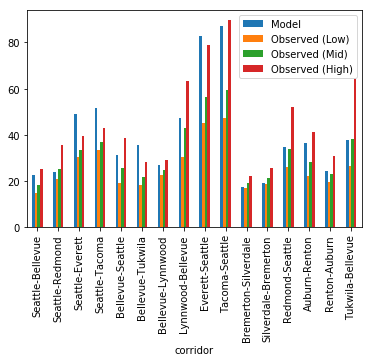

In [19]:
_df.plot(kind='bar')

**PM Travel Times**

In [20]:
df = results_dict['17to18']['svtl2t']
df = pd.merge(df,od_obs,on=['otaz','dtaz'])
df = df[['o_city','d_city','travel_time','optimistic','best_guess','pessimistic','time']]
df['corridor']=df['o_city']+'-'+df['d_city']
df = df[df['time'] == 'am']

df = df.rename(columns={'travel_time':'travel_time_model',
                   'optimistic':'observed_low',
                  'best_guess':'observed_mid',
                   'pessimistic':'observed_high'})
df.index = df.corridor
pd.options.display.float_format = '{:0,.0f}'.format
df = df.drop(['time','corridor'], axis=1)
df = df.rename(columns={'o_city':'From','d_city':'To','travel_time_model':'Model', 
                   'observed_low': 'Observed (Low)', 'observed_mid': 'Observed (Mid)', 'observed_high': 'Observed (High)'})

_df = df[df.index.isin(corridor_list)]
_df.reset_index().drop('corridor', axis=1)

,From,To,Model,Observed (Low),Observed (Mid),Observed (High)
0,Seattle,Bellevue,31,15,19,25
1,Seattle,Redmond,33,21,25,36
2,Seattle,Everett,81,30,33,39
3,Seattle,Tacoma,83,33,37,43
4,Bellevue,Seattle,26,19,26,39
5,Bellevue,Tukwila,41,18,22,28
6,Bellevue,Lynnwood,46,23,25,29
7,Lynnwood,Bellevue,30,31,43,64
8,Everett,Seattle,58,45,56,79
9,Tacoma,Seattle,56,47,60,90


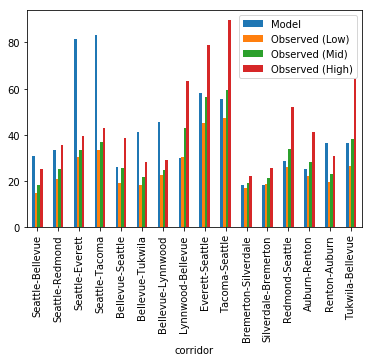

In [21]:
_df.plot(kind='bar')

### Annual Travel Cost per Household 
Out of pocket costs (fuel, tolls, transit fares)

In [22]:
df = trip.groupby('hhno').sum()['travcost']
df = df.reset_index()
df = pd.merge(hh,df,on='hhno',how='left')
df['travcost'] = df['travcost'].fillna(0)
x = df['travcost'].mean()*annual_factor
print '${:0,.0f}'.format(x)

$3,358


In [23]:
max_income = 200000 # in 
income_bins = [i for i in xrange(0,max_income,10000)]
income_bins.append(1000000000)
income_labels = [str(i) for i in xrange(10000,max_income,10000)]
income_labels.append(str(max_income)+'+')
df['income'] = pd.cut(df['hhincome'],bins=income_bins,labels=income_labels)
df = pd.DataFrame(df.groupby('income').mean()['travcost'])
df['annual_cost'] = df['travcost']*annual_factor

Annual costs by income

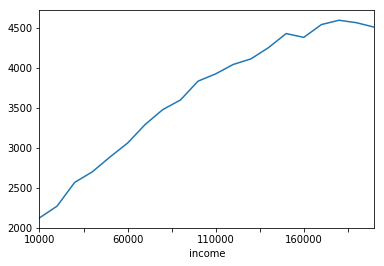

In [24]:
pd.options.display.float_format = '{:0,.2f}'.format
df['annual_cost'].plot()

## Transit Boardings

In [25]:
pd.options.display.float_format = '{:0,.0f}'.format

In [26]:
df = pd.read_excel(r'../../../outputs/transit/transit_summary.xlsx', sheetname='Transit Line Activity')
tod_list = ['5to6','6to7','7to8','8to9','9to10','10to14','14to15','15to16','16to17','17to18','18to20']
df = df[[tod+'_board' for tod in tod_list]+['route_code']]
df = df.fillna(0)
df['line_total'] = df[[tod+'_board' for tod in tod_list]].sum(axis=1)

#Boardings by transit agency
agency_lookup = {
    '1': 'King County Metro',
    '2': 'Pierce Transit',
    '3': 'Community Transit',
    '4': 'Kitsap Transit',
    '5': 'Washington Ferries',
    '6': 'Sound Transit',
    '7': 'Everett Transit'
}
df['agency'] = df['route_code'].astype('str').apply(lambda row: row[0])
df['agency'] = df['agency'].map(agency_lookup)
_df = pd.DataFrame(df.groupby('agency').sum()['line_total'])
print _df
print '-'*40
print 'Total Boardings: ' + str(df['line_total'].sum())

                    line_total
agency                        
Community Transit       89,371
Everett Transit         16,235
King County Metro      832,327
Kitsap Transit          48,163
Pierce Transit          94,018
Sound Transit          613,307
Washington Ferries      17,282
----------------------------------------
Total Boardings: 1710702.23907


# Commute Times

In [27]:
pd.options.display.float_format = '{:0,.2f}'.format

In [28]:
workers = person.loc[person['pwautime']>0]
binned_times = pd.cut(workers['pwautime'], [0, 15, 30, 45, 60, 90, 200])
count_times = pd.value_counts(binned_times).sort_index()
print count_times

(0, 15]      742384
(15, 30]     905953
(30, 45]     519560
(45, 60]     282627
(60, 90]     218846
(90, 200]     59970
Name: pwautime, dtype: int64


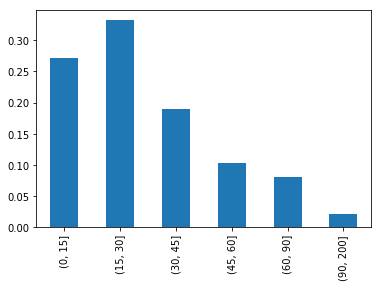

In [29]:
(count_times*1.0/len(workers)).plot.bar()